<h1 style="text-align: center;">Pitch Classification Model</h1>

## Necessary Libraries

In [52]:
import pandas as pd
import numpy as np
import joblib

## ML libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score

## visalization libraries
import seaborn as sns
import plotly.express as px

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch

pd.options.display.max_columns = None

## Data Cleaning

In [53]:
def transform_tagged_pitches(pitch_type: str):
    """
    Maps the pitch of TaggedPitchType to be on the same wavelength as AutoPitchType
    """
    mapping = {'FourSeamFastBall': 'Four-Seam', 
               'Fastball': 'Four-Seam', 
               'TwoSeamFastBall': 'Sinker', 
               'ChangeUp': 'Changeup', 
               'Sweeper': 'Slider',
               'OneSeamFastBall': 'Sinker',
               }
    return mapping.get(pitch_type, pitch_type)

In [54]:
df = pd.read_csv('../../Files/merged_trackman_games.csv', dtype={'HomeTeamForeignID': str, 'AwayTeamForeignID': str}).drop(columns=['HomeTeamForeignID', 'AwayTeamForeignID']).copy()
# df = df[['Pitcher', 'PitcherThrows', 'PitcherTeam', 'TaggedPitchType', 'AutoPitchType', 
#          'RelSpeed', 'VertRelAngle', 'HorzRelAngle', 'SpinRate', 'SpinAxis', 'RelHeight', 'RelSide',
#          'Extension', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle']].copy()

## gets rid of the pitches without any data for it
df = df[~df['AutoPitchType'].isna()].reset_index(drop=True).copy()

## makes the pitch names be consistent
df['AutoPitchType'] = df.apply(lambda x: x['TaggedPitchType'] if x['AutoPitchType'] == 'Other' else x['AutoPitchType'], axis=1)
df['TaggedPitchType'] = df.apply(lambda x: 
                                 x['AutoPitchType'] 
                                 if (x['TaggedPitchType']=='Other' or x['TaggedPitchType']=='Knuckleball' or x['TaggedPitchType']=='Undefined')
                                 else x['TaggedPitchType'], axis=1)

df['TaggedPitchType'] = df['TaggedPitchType'].apply(transform_tagged_pitches)
df['AutoPitchType'] = df['AutoPitchType'].apply(transform_tagged_pitches)

## imputes the null values of Extension
df['Extension'] = df['Extension'].fillna(df.groupby(['Pitcher', 'PitcherThrows', 'PitcherTeam'])['Extension'].transform('mean'))
df['SpinRate'] = df['SpinRate'].fillna(df.groupby(['Pitcher', 'PitcherThrows', 'PitcherTeam', 'AutoPitchType'])['SpinRate'].transform('mean'))
## gets rid of any lingering null rows
df = df[~df['SpinRate'].isna()].reset_index(drop=True).copy()

df['PitcherThrows'] = df['PitcherThrows'].apply(lambda x: x=='Right').astype(int)
df

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
0,1,2025-03-25,18:08:29.92,1,1,"Martin, Landon",1.000365e+09,1,CAL_FUL,"Watson, Rex",1.000336e+09,Left,SAN_TOR,Undefined,1,Top,0,0,0,Four-Seam,Four-Seam,InPlay,Undefined,Popup,Out,1,0,88.86171,-1.466742,-1.379080,1973.862694,199.693179,12:45,5.82053,0.88575,5.86519,-20.13757,15.62883,5.14768,2.77915,0.03336,80.48807,-5.279977,-0.455642,0.430436,82.05061,73.608538,-26.909913,NaN,NaN,NaN,NaN,NaN,34.69425,NaN,NaN,-3.07658,8.82300,-0.77708,50.0,5.69011,2.88805,-128.91094,-3.92086,-5.11995,29.55922,-17.49106,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,d4cb7a60-09de-11f0-91ec-41cc551cf82d,87.56798,110.06968,NaN,8.37364,NaN,NaN,NaN,0.66494,3.16207,-0.64947,4f69f254-7555-401e-b034-118e07d33b1e,2025-03-26,01:08:29.92,2025-03-25T18:08:29.9246592-07:00,2025-03-26T01:08:29.9246592Z,NaN,v3,25 March 2025 21:00-sandiego@calstfull,"Ortega, Max",703672,Right,CAL_FUL,dc341f6c-8981-4044-addd-07f5b0d70724,54.63359,-129.96908,14.77961,5.81926,-3.29473,-8.74553,-0.88374,3.07133,-2.55997,NaN,0.66497,30.27848,-13.0026,3.70082,-0.22191,-0.45891,0.20178,0.03247,-0.02858,3.16206,115.45012,-29.52616,3.8369,-0.86047,0.29714,-0.13366,0.0413,-0.00549,-0.64945,-15.37252,-3.67539,1.43911,0.00628,-0.32618,0.15003,0.00737,-0.01489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,Medium,Undefined,NaN,NaN,NaN
1,2,2025-03-25,18:09:07.68,2,1,"Martin, Landon",1.000365e+09,1,CAL_FUL,"Libed, Nico",8.222970e+05,Right,SAN_TOR,Undefined,1,Top,1,0,0,Four-Seam,Four-Seam,StrikeCalled,Undefined,Undefined,Undefined,0,0,88.80676,-2.887698,-1.987311,2086.802197,201.088936,12:45,5.80890,0.92208,5.79721,-19.77792,16.16832,5.75107,1.47086,-0.44790,80.64136,-6.616077,-0.957190,0.431517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.55894,9.51245,-0.76220,50.0,5.55954,4.22276,-128.67299,

In [55]:
display(df['TaggedPitchType'].unique())
display(df['AutoPitchType'].unique())
display(df.isna().sum())

array(['Four-Seam', 'Slider', 'Curveball', 'Sinker', 'Changeup',
       'Splitter', 'Cutter'], dtype=object)

array(['Four-Seam', 'Slider', 'Curveball', 'Cutter', 'Changeup', 'Sinker',
       'Splitter'], dtype=object)

PitchNo                               0
Date                                  0
Time                                  0
PAofInning                            0
PitchofPA                             0
                                  ...  
HitLaunchConfidence               25589
HitLandingConfidence              25589
CatcherThrowCatchConfidence       34567
CatcherThrowReleaseConfidence     34567
CatcherThrowLocationConfidence    34567
Length: 164, dtype: int64

## EDA

In [56]:
def pitch_type_group(pitch_type: str):
    """
    Maps out the pitch type and outputs its pitch group (e.g., 4S are fastballs, SL are breaking balls, etc.)
    """
    pitch_groups = {'Fastball': ['Sinker', 'Four-Seam', 'Cutter'],
                    'Breakingball': ['Slider', 'Curveball'],
                    'Offspeed': ['Changeup', 'Splitter']
                    }
    for k, v in pitch_groups.items():
        if pitch_type in v:
            return k
    return np.nan

In [57]:
## finds the pitch groups from each classification system
df['TaggedGroup'] = df['TaggedPitchType'].apply(pitch_type_group)
df['AutoGroup'] = df['AutoPitchType'].apply(pitch_type_group)

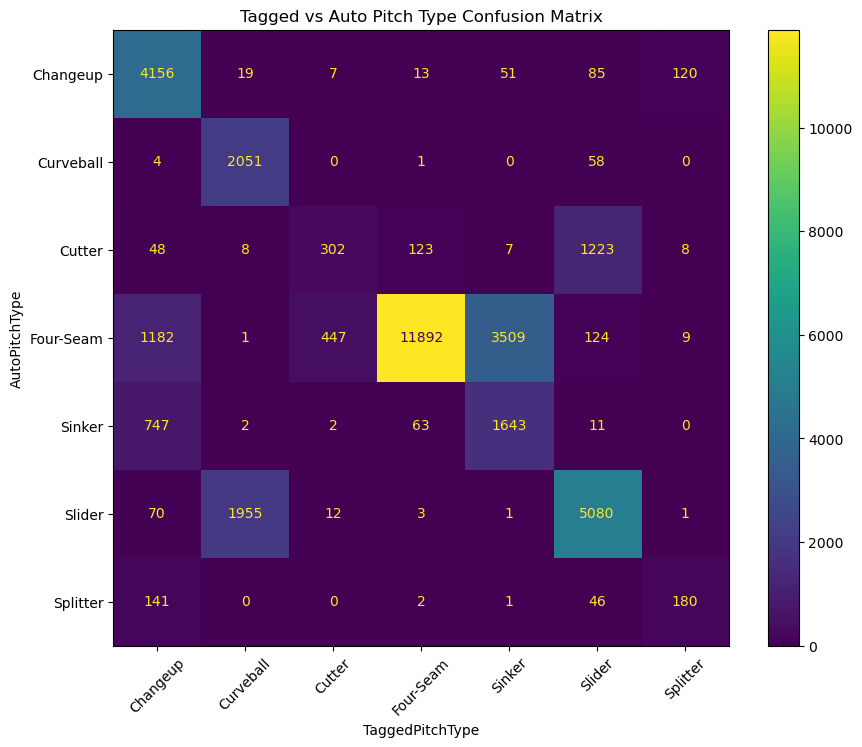

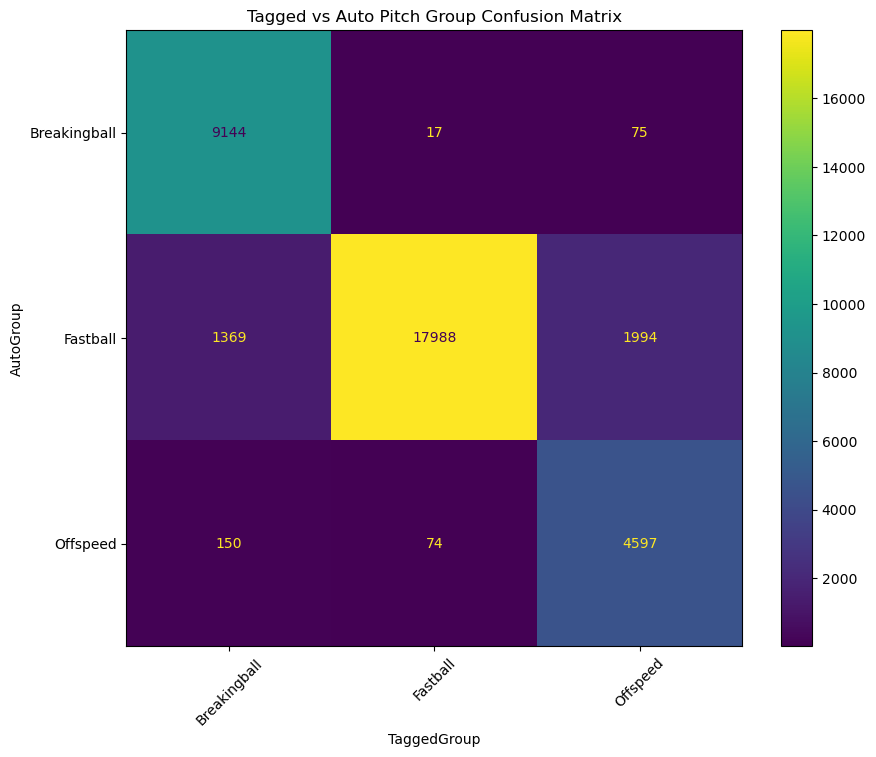

In [58]:
## individual pitches
labels = sorted(set(df["TaggedPitchType"].unique()) | set(df["AutoPitchType"].unique()))
cm = confusion_matrix(df["TaggedPitchType"], df["AutoPitchType"], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.viridis)
ax.set_xlabel("TaggedPitchType")
ax.set_ylabel("AutoPitchType")
plt.title("Tagged vs Auto Pitch Type Confusion Matrix")
plt.show()

## pitch groups
group_labels = sorted(set(df["TaggedGroup"].unique()) | set(df["AutoGroup"].unique()))
group_cm = confusion_matrix(df["TaggedGroup"], df["AutoGroup"], labels=group_labels)
group_disp = ConfusionMatrixDisplay(confusion_matrix=group_cm, display_labels=group_labels)
fig, ax = plt.subplots(figsize=(10, 8))
group_disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.viridis)
ax.set_xlabel("TaggedGroup")
ax.set_ylabel("AutoGroup")
plt.title("Tagged vs Auto Pitch Group Confusion Matrix")
plt.show()

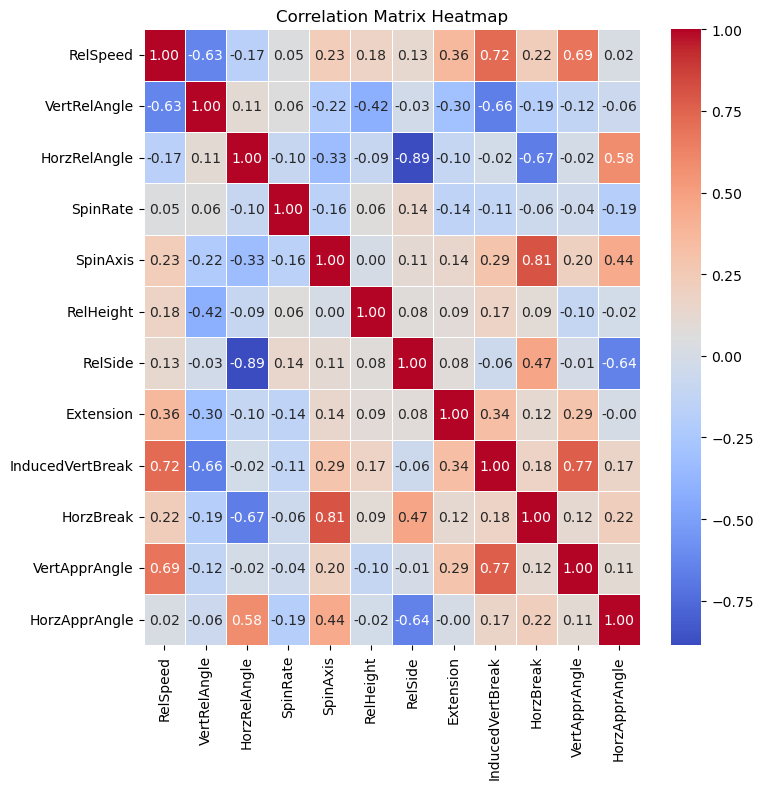

In [59]:
plt.figure(figsize=(8, 8)) 
correlation_matrix = df[['RelSpeed', 'VertRelAngle', 'HorzRelAngle', 'SpinRate', 'SpinAxis', 'RelHeight', 'RelSide', 
                         'Extension', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [60]:
training_data = df[df['TaggedGroup'] == df['AutoGroup']].reset_index(drop=True).copy()
training_data

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup
0,1,2025-03-25,18:08:29.92,1,1,"Martin, Landon",1.000365e+09,1,CAL_FUL,"Watson, Rex",1.000336e+09,Left,SAN_TOR,Undefined,1,Top,0,0,0,Four-Seam,Four-Seam,InPlay,Undefined,Popup,Out,1,0,88.86171,-1.466742,-1.379080,1973.862694,199.693179,12:45,5.82053,0.88575,5.86519,-20.13757,15.62883,5.14768,2.77915,0.03336,80.48807,-5.279977,-0.455642,0.430436,82.05061,73.608538,-26.909913,NaN,NaN,NaN,NaN,NaN,34.69425,NaN,NaN,-3.07658,8.82300,-0.77708,50.0,5.69011,2.88805,-128.91094,-3.92086,-5.11995,29.55922,-17.49106,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,d4cb7a60-09de-11f0-91ec-41cc551cf82d,87.56798,110.06968,NaN,8.37364,NaN,NaN,NaN,0.66494,3.16207,-0.64947,4f69f254-7555-401e-b034-118e07d33b1e,2025-03-26,01:08:29.92,2025-03-25T18:08:29.9246592-07:00,2025-03-26T01:08:29.9246592Z,NaN,v3,25 March 2025 21:00-sandiego@calstfull,"Ortega, Max",703672,Right,CAL_FUL,dc341f6c-8981-4044-addd-07f5b0d70724,54.63359,-129.96908,14.77961,5.81926,-3.29473,-8.74553,-0.88374,3.07133,-2.55997,NaN,0.66497,30.27848,-13.0026,3.70082,-0.22191,-0.45891,0.20178,0.03247,-0.02858,3.16206,115.45012,-29.52616,3.8369,-0.86047,0.29714,-0.13366,0.0413,-0.00549,-0.64945,-15.37252,-3.67539,1.43911,0.00628,-0.32618,0.15003,0.00737,-0.01489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,Medium,Undefined,NaN,NaN,NaN,Fastball,Fastball
1,2,2025-03-25,18:09:07.68,2,1,"Martin, Landon",1.000365e+09,1,CAL_FUL,"Libed, Nico",8.222970e+05,Right,SAN_TOR,Undefined,1,Top,1,0,0,Four-Seam,Four-Seam,StrikeCalled,Undefined,Undefined,Undefined,0,0,88.80676,-2.887698,-1.987311,2086.802197,201.088936,12:45,5.80890,0.92208,5.79721,-19.77792,16.16832,5.75107,1.47086,-0.44790,80.64136,-6.616077,-0.957190,0.431517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.55894,9.51245,-

In [61]:
## 4-seam fastballs
training_data[training_data['TaggedPitchType']=='Four-Seam'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,15848.000000,15848.000000,15848.000000,15848.000000,15848.000000,15848.000000,15848.000000
mean,89.983593,2228.256732,188.507826,18.287546,2.856044,5.895451,0.441337
std,2.775815,159.113184,33.027922,4.021868,11.064495,0.453105,1.604245
min,80.664270,1602.678924,82.148615,-15.138980,-26.489030,2.358650,-3.593960
25%,88.027678,2120.596295,156.261569,15.941210,-7.780905,5.646068,-1.183080
50%,89.696360,2224.941477,199.198140,18.697725,6.380180,5.898950,1.060530
75%,91.582548,2339.294405,212.999394,21.099275,11.530950,6.176505,1.664645
max,100.262930,2746.632478,343.373462,37.688640,25.549340,7.189550,4.860480


In [62]:
## Sinkers
training_data[training_data['TaggedPitchType']=='Sinker'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000,1708.000000
mean,90.179301,2121.936721,196.402650,9.552862,4.610251,5.438404,0.568171
std,1.925283,162.820918,64.794185,4.328664,17.912590,0.490624,1.974695
min,84.130540,1601.265496,63.876383,-9.042410,-28.516470,3.460760,-3.799850
25%,88.896372,2022.894590,120.641716,7.393230,-17.254168,5.146660,-1.460573
50%,90.004695,2128.163559,235.711489,10.189965,16.054335,5.511840,1.638205
75%,91.380418,2231.270178,247.484863,12.476000,19.179085,5.769870,2.117850
max,96.762680,2679.749104,302.610051,23.702970,27.920720,6.712810,3.794380


In [63]:
## cutters
training_data[training_data['TaggedPitchType']=='Cutter'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000,432.000000
mean,87.716700,2311.628743,187.396984,11.703773,1.395119,6.037338,-0.121551
std,2.687322,156.572543,19.714265,2.865527,3.660131,0.436437,1.823341
min,80.703740,1845.052881,136.812467,5.023110,-9.041780,4.717840,-2.446840
25%,85.935930,2214.985660,174.369531,9.954677,-1.192927,5.738530,-2.003720
50%,87.836535,2321.013437,187.799730,11.514140,1.476500,5.945335,0.678545
75%,89.389085,2407.323731,199.270153,13.381258,3.672990,6.375680,1.633282
max,95.908080,2735.148304,243.793661,25.725010,13.104770,6.959910,3.433090


In [64]:
## changeups
training_data[training_data['TaggedPitchType']=='Changeup'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000,4276.000000
mean,80.710042,1796.324971,191.270067,7.798288,3.045891,5.687310,0.293319
std,3.345806,361.219923,70.400885,5.164563,16.370030,0.433717,1.877194
min,66.096850,725.462476,30.674580,-9.751740,-27.353720,3.562440,-3.764240
25%,77.949467,1523.243399,114.974915,4.213795,-14.599670,5.460307,-1.667347
50%,80.688755,1778.573148,230.342065,8.136915,11.874870,5.654000,1.238375
75%,83.383837,2062.017137,250.811713,11.376780,17.511740,5.915690,1.844928
max,90.409420,2745.807227,334.989084,25.227420,27.750680,6.963470,3.701120


In [65]:
## splitters
training_data[training_data['TaggedPitchType']=='Splitter'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000,321.000000
mean,82.581870,1178.965257,243.907325,4.643746,10.084607,5.677877,1.596560
std,2.973855,260.476614,49.579819,5.641386,7.874137,0.372593,1.184887
min,75.285770,714.194745,4.455092,-14.311030,-19.192100,4.591680,-2.706580
25%,80.314800,976.382559,236.164873,0.956930,8.993980,5.527270,1.484920
50%,81.892650,1102.917947,250.631340,5.117600,12.311460,5.777830,2.018350
75%,85.384230,1422.061787,272.652774,8.421820,14.639970,5.900520,2.234960
max,88.366480,2301.875189,324.893221,18.999030,20.103400,7.119180,2.976070


In [66]:
## Curveballs
training_data[training_data['TaggedPitchType']=='Curveball'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,2109.000000,2109.000000,2109.000000,2109.000000,2109.000000,2109.000000,2109.000000
mean,76.028576,2425.300630,95.318060,-11.672527,-6.224151,5.973912,0.850298
std,4.088181,274.793380,116.685103,5.183107,9.325500,0.395492,1.265585
min,61.910670,1666.163931,0.334041,-26.981160,-26.031230,4.574440,-3.029860
25%,73.921300,2230.381233,27.801554,-15.356230,-12.952050,5.686810,0.342920
50%,76.273640,2419.594474,42.430613,-11.242530,-8.428270,5.968190,1.111360
75%,78.742550,2635.884334,62.978902,-8.004810,-2.494690,6.298440,1.714470
max,88.037200,3343.169836,359.793560,6.821340,24.577100,6.943380,3.497590


In [67]:
## Sliders
training_data[training_data['TaggedPitchType']=='Slider'][['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].describe()

,RelSpeed,SpinRate,SpinAxis,InducedVertBreak,HorzBreak,RelHeight,RelSide
count,7035.000000,7035.000000,7035.000000,7035.000000,7035.000000,7035.000000,7035.000000
mean,79.999785,2386.061846,152.702107,1.142973,-2.587646,5.628499,0.613185
std,3.339814,242.174045,90.796249,4.950492,10.167189,0.510557,1.795074
min,63.052910,1044.017758,0.062975,-18.933080,-27.041350,2.938360,-3.996870
25%,77.752655,2219.518797,78.713677,-2.068010,-9.530830,5.395870,-1.030090
50%,80.078070,2390.272116,117.219870,1.442870,-3.891770,5.670240,1.321200
75%,82.384765,2554.772937,247.718815,4.531935,5.162405,5.933330,1.941220
max,89.505290,3445.185833,359.887028,19.555520,28.546750,7.062000,4.916360


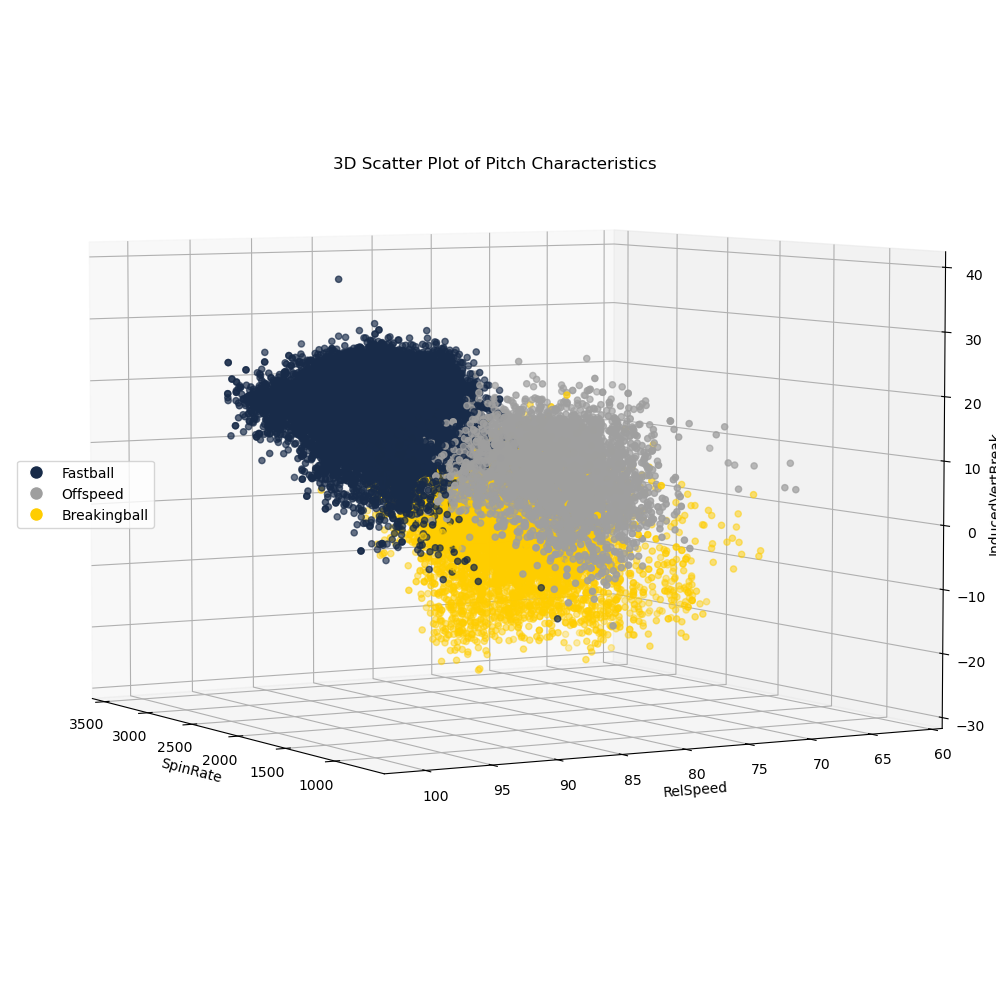

In [68]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D

colors = training_data['AutoGroup'].map({'Breakingball': '#FFCD00', 'Fastball': '#182B49', 'Offspeed': '#9f9f9f'})

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Fastball', markerfacecolor='#182B49', markersize=10), 
                   Line2D([0], [0], marker='o', color='w', label='Offspeed', markerfacecolor='#9f9f9f', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Breakingball', markerfacecolor='#FFCD00', markersize=10),
                   ]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(training_data['SpinRate'], training_data['RelSpeed'], training_data['InducedVertBreak'], c=colors, marker='o')
ax.set_xlabel('SpinRate')
ax.set_ylabel('RelSpeed')
ax.set_zlabel('InducedVertBreak', labelpad=0)
ax.set_title('3D Scatter Plot of Pitch Characteristics', y=0.9)
ax.view_init(elev=5, azim=150)
ax.legend(handles=legend_elements, loc='center left')
plt.tight_layout()
plt.show()

## Pitch Group Model

Setting up the training set

In [69]:
group_training_data = training_data.copy()
group_training_data['group_cat_code'] = group_training_data['TaggedGroup'].astype('category').cat.codes
group_training_data['pitch_cat_code'] = group_training_data['TaggedPitchType'].astype('category').cat.codes

In [70]:
lhp = group_training_data[group_training_data['PitcherThrows']==0].reset_index(drop=True).copy()
group_X_lhp = (lhp[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
               .transform(lambda x: (x-x.mean()) / x.std())
               ).values
group_y_lhp = lhp['group_cat_code'].values

rhp = group_training_data[group_training_data['PitcherThrows']==1].reset_index(drop=True).copy()
group_X_rhp = (rhp[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
               .transform(lambda x: (x-x.mean()) / x.std())
               ).values
group_y_rhp = rhp['group_cat_code'].values

In [71]:
def xgboost_model(X, y):
    """
    Using an xgboost classifier model with bayesian optimization hypertuning to classify pitch type
    """
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
    xgb = XGBClassifier(objective="multi:softprob", num_class=3, eval_metric="mlogloss", tree_method="hist", random_state=42)

    param_grid = {"n_estimators": (100, 500), ## num of trees in the model
                "learning_rate": (0.01, 0.3, "log-uniform"), ## the rate at which the model makes changes to the weights
                "max_depth": (3, 7), ## how deep the trees can be
                "min_child_weight": (0.1, 5, "log-uniform"), ## min num of obs can be present in each node of the tree
                "subsample": (0.7, 0.9), ## num of obs used to build each tree
                "colsample_bytree": (0.6, 1.0), ## num of features used to build each tree
                "reg_alpha": (1e-2, 1, "log-uniform"), ## controls the strength of regularization (l1)
                "reg_lambda": (1e-2, 1, "log-uniform"), ## controls the strength of regularization (l2)
                "gamma": (0.0, 2.0), ## min loss reduction required to make a split
                }

    ## 3-fold stratified cv with bayesian optimization hypertuning to find the best xgboost model
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    opt = BayesSearchCV(estimator=xgb, search_spaces=param_grid, n_iter=20, cv=cv, n_jobs=-1, scoring="neg_log_loss", verbose=0, random_state=42, refit=True)
    opt.fit(X_train, y_train)

    ## final training with validation split: checking generalization
    best_xgb = opt.best_estimator_
    best_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    y_val_prob = best_xgb.predict_proba(X_val)
    y_val_pred = best_xgb.predict(X_val)

    ## evaluation metrics
    print("Log loss:", log_loss(y_val, y_val_prob))
    print("Accuracy:", accuracy_score(y_val, y_val_pred))

    ## confusion matrix for the model's results
    cat_dtype = group_training_data['TaggedGroup'].astype('category')
    class_names = cat_dtype.cat.categories.tolist()
    xgb_cm = confusion_matrix(y_val, y_val_pred)
    xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    xgb_disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.viridis)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.title("XGBoost Validation Confusion Matrix")
    plt.show()

    ## displays the importance of each feature used (# is the # of times each feature is used in splits across the trees)
    feature_names = ['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']
    best_xgb.get_booster().feature_names = feature_names
    plot_importance(best_xgb, max_num_features=7)
    plt.show()

    return best_xgb

Log loss: 0.014106829425093398
Accuracy: 0.9972222222222222


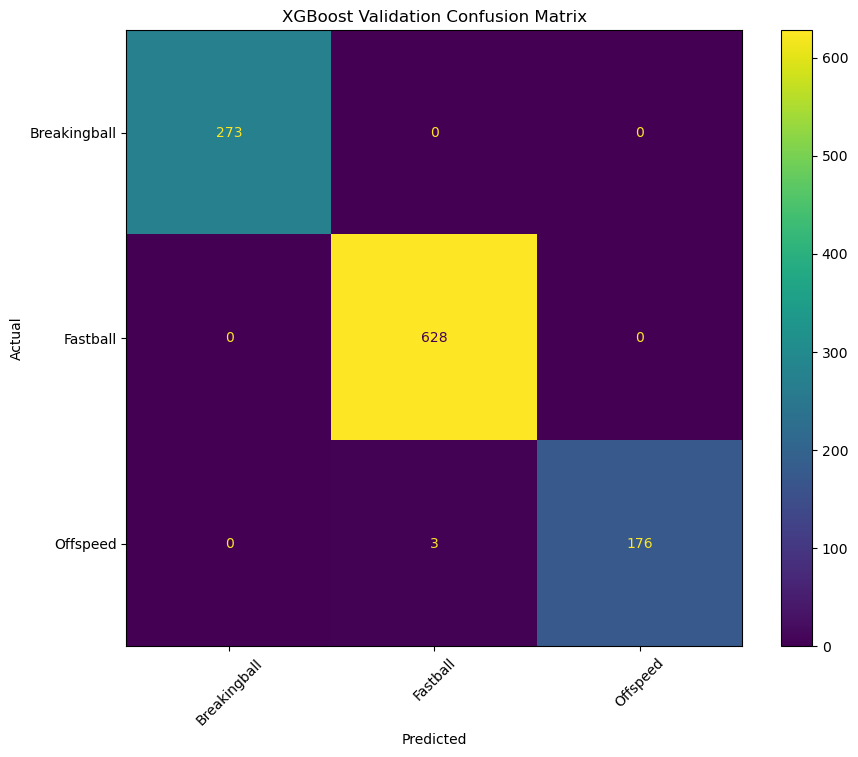

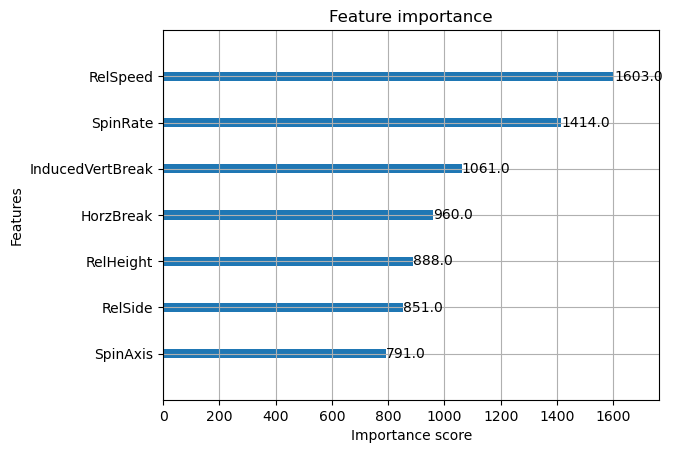

In [72]:
lhp_xgb = xgboost_model(group_X_lhp, group_y_lhp)

Log loss: 0.014844849202269523
Accuracy: 0.9952244508118434


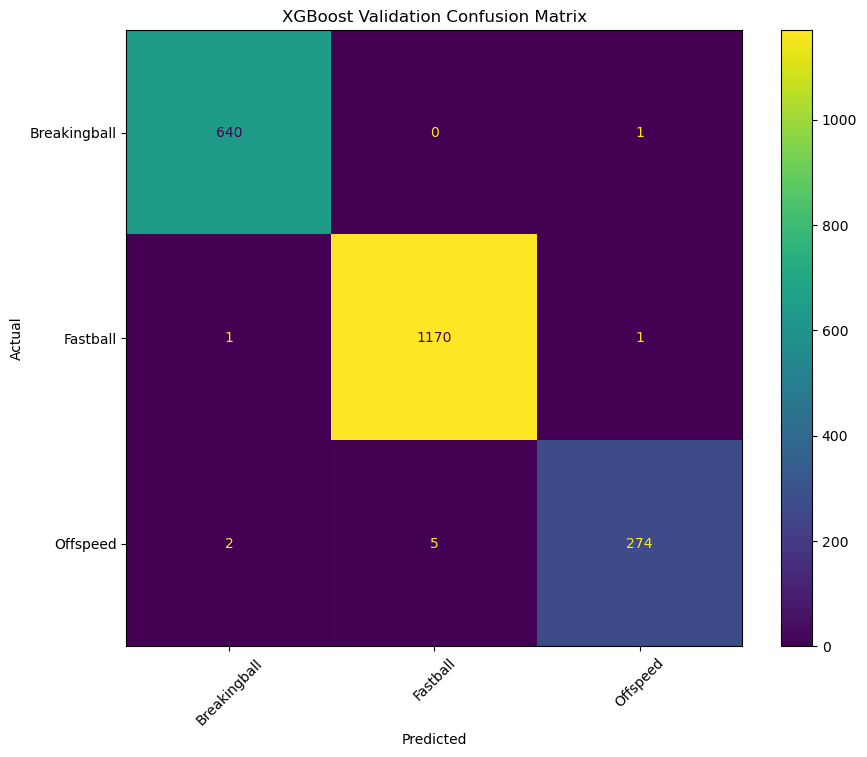

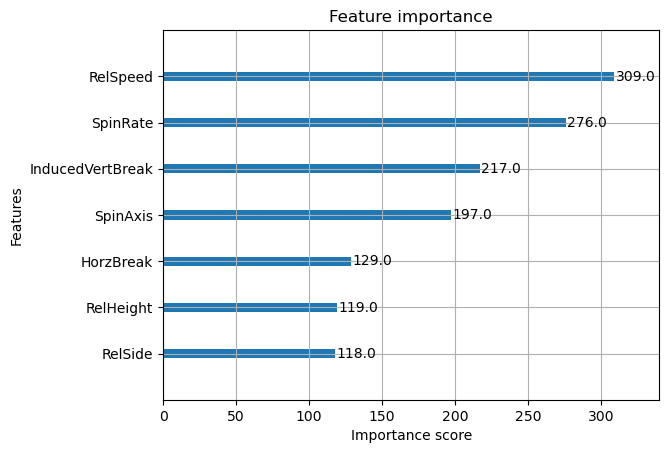

In [73]:
rhp_xgb = xgboost_model(group_X_rhp, group_y_rhp)

Evaluating the model

In [74]:
joblib.dump(lhp_xgb, "lhp_xgb.pkl")
lhp_xgb = joblib.load("lhp_xgb.pkl")
display(lhp_xgb)

joblib.dump(rhp_xgb, "rhp_xgb.pkl")
rhp_xgb = joblib.load("rhp_xgb.pkl")
display(rhp_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9069493207263146, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.16340549599414553,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=0.1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=370, n_jobs=None, num_class=3, ...)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9933711875464454, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=0.378242967864947, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.29999999999999993,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=0.3551799059721739, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_class=3, ...)

In [75]:
display(group_training_data
        .groupby(['group_cat_code', 'PitcherThrows'])[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
        .mean()
        )
display(group_training_data
        .groupby(['group_cat_code', 'PitcherThrows'])[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
        .std()
        )

RelSpeed     SpinRate    SpinAxis  \
group_cat_code PitcherThrows                                       
0              0              77.554514  2342.013781  268.128987   
               1              79.735809  2417.747691   84.618405   
1              0              88.696549  2167.682968  146.340383   
               1              90.617866  2248.272263  212.202808   
2              0              79.580160  1737.839943  110.623158   
               1              81.641677  1762.985160  248.520846   

                              InducedVertBreak  HorzBreak  RelHeight   RelSide  
group_cat_code PitcherThrows                                                    
0              0                     -0.168506   9.127588   5.602097 -1.662880  
               1                     -2.513807  -8.778120   5.753384  1.661471  
1              0                     16.653408 -11.068983   5.712550 -1.630060  
               1                     17.646394  10.516167   5.932003  1.548509  
2              0                      7.369029 -15.663792   5.552257 -1.834585  
               1                      7.710791  15.737077   5.772040  1.794129

RelSpeed    SpinRate   SpinAxis  \
group_cat_code PitcherThrows                                    
0              0              3.335780  231.439160  50.245910   
               1              3.945075  255.021584  56.698690   
1              0              2.142695  147.130242  21.221831   
               1              2.770779  164.205086  18.867940   
2              0              2.767923  367.442542  20.456324   
               1              3.448420  400.898803  21.406717   

                              InducedVertBreak  HorzBreak  RelHeight   RelSide  
group_cat_code PitcherThrows                                                    
0              0                      6.427582   5.769270   0.521369  0.802788  
               1                      7.618979   5.945910   0.494961  0.706177  
1              0                      4.882180   6.177264   0.493747  0.679049  
               1                      4.799415   5.516240   0.448598  0.644528  
2              0                      5.136321   4.921933   0.396775  0.602561  
               1                      5.334442   4.626889   0.428045  0.594254

In [76]:
def prob_df(model, df, handedness, label_col="TaggedGroup"):
    """
    
    """
    X_pred_group = df[df['PitcherThrows'] == handedness].reset_index(drop=True).copy()
    
    cat_dtype = training_data[label_col].astype('category')
    classes = cat_dtype.cat.categories.tolist()
    
    X_pred_group['group_cat_code'] = training_data['TaggedGroup'].astype('category').cat.codes
    X_pred_group = (X_pred_group[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].transform(lambda x: (x - x.mean()) / x.std()))
    probs = model.predict_proba(X_pred_group.values)
    class_labels = [classes[i] for i in model.classes_]
    probs_df = pd.DataFrame(probs, columns=[f"p_{c}" for c in class_labels])
    probs_df = probs_df.round(3)

    training_data_w_prob = pd.concat([df[df['PitcherThrows'] == handedness].reset_index(drop=True), probs_df], axis=1)
    
    return training_data_w_prob

In [77]:
test_data = df[df['TaggedGroup'] != df['AutoGroup']].reset_index(drop=True).copy()
test_data

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup
0,70,2025-03-25,18:48:46.87,5,4,"Horn, David",7.026150e+05,1,SAN_TOR,"Latta, Maddox",8.239440e+05,Right,CAL_FUL,Undefined,2,Bottom,2,2,1,Sinker,Changeup,BallCalled,Undefined,Undefined,Undefined,0,0,86.93549,-2.906844,-2.950047,1755.928970,231.326511,1:45,6.05073,0.51236,6.03091,-25.53001,11.72642,13.01351,1.22540,-1.13756,78.99813,-7.682912,-0.608986,0.439311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.62792,7.31890,-0.28873,50.0,5.80936,5.96497,-125.91925,-7.19781,-12.11729,28.09687,-20.54768,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,75787f30-09e4-11f0-91ec-41cc551cf82d,85.79899,NaN,NaN,7.93736,NaN,NaN,NaN,NaN,NaN,NaN,4f69f254-7555-401e-b034-118e07d33b1e,2025-03-26,01:48:46.87,2025-03-25T18:48:46.8700000-07:00,2025-03-26T01:48:46.8700000Z,NaN,v3,25 March 2025 21:00-sandiego@calstfull,"Libed, Nico",822297,Right,SAN_TOR,60501b6c-ec3d-459d-aef1-e9711920d980,54.46817,-126.91234,14.04844,6.05094,-6.47155,-10.27384,-0.50713,6.39325,-6.05864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,Fastball,Offspeed
1,73,2025-03-25,18:51:33.85,6,1,"Horn, David",7.026150e+05,1,SAN_TOR,"Kirchner, Andrew",1.000213e+09,Left,CAL_FUL,Undefined,2,Bottom,2,0,0,Four-Seam,Slider,BallCalled,Undefined,Undefined,Undefined,0,0,87.82298,1.188774,1.594113,2071.183221,158.285959,11:15,6.13399,0.50984,5.83308,-28.30415,8.20008,-2.78728,4.88089,1.75972,79.75143,-4.091422,1.094758,0.434854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.88106,4.20961,-0.63833,50.0,6.21453,-3.42636,-127.42507,1.68882,3.07574,27.53432,-25.29095,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,d90062c0-09e4-11f0-91ec-41cc

## Individual Pitch Model

In [78]:
merged_df = (pd.concat([prob_df(rhp_xgb, training_data, 1), 
                       prob_df(lhp_xgb, training_data, 0), 
                       prob_df(rhp_xgb, test_data, 1), 
                       prob_df(lhp_xgb, test_data, 0)])
                       .reset_index(drop=True)
                       .copy()
                       )
merged_df

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup,p_Breakingball,p_Fastball,p_Offspeed
0,1,2025-03-25,18:08:29.92,1,1,"Martin, Landon",1.000365e+09,1,CAL_FUL,"Watson, Rex",1.000336e+09,Left,SAN_TOR,Undefined,1,Top,0,0,0,Four-Seam,Four-Seam,InPlay,Undefined,Popup,Out,1,0,88.86171,-1.466742,-1.379080,1973.862694,199.693179,12:45,5.82053,0.88575,5.86519,-20.13757,15.62883,5.14768,2.77915,0.03336,80.48807,-5.279977,-0.455642,0.430436,82.05061,73.608538,-26.909913,NaN,NaN,NaN,NaN,NaN,34.69425,NaN,NaN,-3.07658,8.82300,-0.77708,50.0,5.69011,2.88805,-128.91094,-3.92086,-5.11995,29.55922,-17.49106,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,d4cb7a60-09de-11f0-91ec-41cc551cf82d,87.56798,110.06968,NaN,8.37364,NaN,NaN,NaN,0.66494,3.16207,-0.64947,4f69f254-7555-401e-b034-118e07d33b1e,2025-03-26,01:08:29.92,2025-03-25T18:08:29.9246592-07:00,2025-03-26T01:08:29.9246592Z,NaN,v3,25 March 2025 21:00-sandiego@calstfull,"Ortega, Max",703672,Right,CAL_FUL,dc341f6c-8981-4044-addd-07f5b0d70724,54.63359,-129.96908,14.77961,5.81926,-3.29473,-8.74553,-0.88374,3.07133,-2.55997,NaN,0.66497,30.27848,-13.00260,3.70082,-0.22191,-0.45891,0.20178,0.03247,-0.02858,3.16206,115.45012,-29.52616,3.83690,-0.86047,0.29714,-0.13366,0.04130,-0.00549,-0.64945,-15.37252,-3.67539,1.43911,0.00628,-0.32618,0.15003,0.00737,-0.01489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,Medium,Undefined,NaN,NaN,NaN,Fastball,Fastball,0.0,1.000,0.000
1,2,2025-03-25,18:09:07.68,2,1,"Martin, Landon",1.000365e+09,1,CAL_FUL,"Libed, Nico",8.222970e+05,Right,SAN_TOR,Undefined,1,Top,1,0,0,Four-Seam,Four-Seam,StrikeCalled,Undefined,Undefined,Undefined,0,0,88.80676,-2.887698,-1.987311,2086.802197,201.088936,12:45,5.80890,0.92208,5.79721,-19.77792,16.16832,5.75107,1.47086,-0.44790,80.64136,-6.616077,-0.957190,0.431517,NaN,Na

In [79]:
training_data_indiv = merged_df[merged_df['TaggedPitchType'] == merged_df['AutoPitchType']].reset_index(drop=True).copy()
training_data_indiv

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup,p_Breakingball,p_Fastball,p_Offspeed
0,1,2025-03-25,18:08:29.92,1,1,"Martin, Landon",1.000365e+09,1,CAL_FUL,"Watson, Rex",1.000336e+09,Left,SAN_TOR,Undefined,1,Top,0,0,0,Four-Seam,Four-Seam,InPlay,Undefined,Popup,Out,1,0,88.86171,-1.466742,-1.379080,1973.862694,199.693179,12:45,5.82053,0.88575,5.86519,-20.13757,15.62883,5.14768,2.77915,0.03336,80.48807,-5.279977,-0.455642,0.430436,82.05061,73.608538,-26.909913,NaN,NaN,NaN,NaN,NaN,34.69425,NaN,NaN,-3.07658,8.82300,-0.77708,50.0,5.69011,2.88805,-128.91094,-3.92086,-5.11995,29.55922,-17.49106,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,d4cb7a60-09de-11f0-91ec-41cc551cf82d,87.56798,110.06968,NaN,8.37364,NaN,NaN,NaN,0.66494,3.16207,-0.64947,4f69f254-7555-401e-b034-118e07d33b1e,2025-03-26,01:08:29.92,2025-03-25T18:08:29.9246592-07:00,2025-03-26T01:08:29.9246592Z,NaN,v3,25 March 2025 21:00-sandiego@calstfull,"Ortega, Max",703672,Right,CAL_FUL,dc341f6c-8981-4044-addd-07f5b0d70724,54.63359,-129.96908,14.77961,5.81926,-3.29473,-8.74553,-0.88374,3.07133,-2.55997,NaN,0.66497,30.27848,-13.0026,3.70082,-0.22191,-0.45891,0.20178,0.03247,-0.02858,3.16206,115.45012,-29.52616,3.8369,-0.86047,0.29714,-0.13366,0.0413,-0.00549,-0.64945,-15.37252,-3.67539,1.43911,0.00628,-0.32618,0.15003,0.00737,-0.01489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,Medium,Undefined,NaN,NaN,NaN,Fastball,Fastball,0.0,1.0,0.0
1,2,2025-03-25,18:09:07.68,2,1,"Martin, Landon",1.000365e+09,1,CAL_FUL,"Libed, Nico",8.222970e+05,Right,SAN_TOR,Undefined,1,Top,1,0,0,Four-Seam,Four-Seam,StrikeCalled,Undefined,Undefined,Undefined,0,0,88.80676,-2.887698,-1.987311,2086.802197,201.088936,12:45,5.80890,0.92208,5.79721,-19.77792,16.16832,5.75107,1.47086,-0.44790,80.64136,-6.616077,-0.957190,0.431517,NaN,NaN,NaN,N

In [80]:
indiv_training_data = training_data_indiv.copy()
indiv_training_data['pitch_cat_code'] = indiv_training_data['TaggedPitchType'].astype('category').cat.codes

In [81]:
lhp = indiv_training_data[indiv_training_data['PitcherThrows']==0].reset_index(drop=True).copy()
indiv_X_lhp = (lhp[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
               .transform(lambda x: (x-x.mean()) / x.std())
               )
indiv_X_lhp.loc[:, 'p_Breakingball'] = lhp['p_Breakingball']
indiv_X_lhp.loc[:, 'p_Fastball'] = lhp['p_Fastball']
indiv_X_lhp.loc[:, 'p_Offspeed'] = lhp['p_Offspeed']
indiv_X_lhp = indiv_X_lhp.values
indiv_y_lhp = lhp['pitch_cat_code'].values

rhp = indiv_training_data[indiv_training_data['PitcherThrows']==1].reset_index(drop=True).copy()
indiv_X_rhp = (rhp[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']]
               .transform(lambda x: (x-x.mean()) / x.std())
               )
indiv_X_rhp.loc[:, 'p_Breakingball'] = rhp['p_Breakingball']
indiv_X_rhp.loc[:, 'p_Fastball'] = rhp['p_Fastball']
indiv_X_rhp.loc[:, 'p_Offspeed'] = rhp['p_Offspeed']
indiv_X_rhp = indiv_X_rhp.values
indiv_y_rhp = rhp['pitch_cat_code'].values

In [82]:
def xgboost_model_indiv(X, y):
    """
    Using an xgboost classifier model with bayesian optimization hypertuning to classify pitch type
    """
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
    xgb = XGBClassifier(objective="multi:softprob", num_class=7, eval_metric="mlogloss", tree_method="hist", random_state=42)

    param_grid = {"n_estimators": (100, 500), ## num of trees in the model
                "learning_rate": (0.01, 0.3, "log-uniform"), ## the rate at which the model makes changes to the weights
                "max_depth": (3, 7), ## how deep the trees can be
                "min_child_weight": (0.1, 5, "log-uniform"), ## min num of obs can be present in each node of the tree
                "subsample": (0.7, 0.9), ## num of obs used to build each tree
                "colsample_bytree": (0.6, 1.0), ## num of features used to build each tree
                "reg_alpha": (1e-2, 1, "log-uniform"), ## controls the strength of regularization (l1)
                "reg_lambda": (1e-2, 1, "log-uniform"), ## controls the strength of regularization (l2)
                "gamma": (0.0, 2.0), ## min loss reduction required to make a split
                }

    ## 3-fold stratified cv with bayesian optimization hypertuning to find the best xgboost model
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    opt = BayesSearchCV(estimator=xgb, search_spaces=param_grid, n_iter=20, cv=cv, n_jobs=-1, scoring="neg_log_loss", verbose=0, random_state=42, refit=True)
    opt.fit(X_train, y_train)

    ## final training with validation split: checking generalization
    best_xgb = opt.best_estimator_
    best_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    y_val_prob = best_xgb.predict_proba(X_val)
    y_val_pred = best_xgb.predict(X_val)

    ## evaluation metrics
    print("Log loss:", log_loss(y_val, y_val_prob))
    print("Accuracy:", accuracy_score(y_val, y_val_pred))

    ## confusion matrix for the model's results
    cat_dtype = group_training_data['TaggedPitchType'].astype('category')
    class_names = cat_dtype.cat.categories.tolist()
    xgb_cm = confusion_matrix(y_val, y_val_pred)
    xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(10, 8))
    xgb_disp.plot(ax=ax, xticks_rotation=45, cmap=plt.cm.viridis)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    plt.title("XGBoost Validation Confusion Matrix")
    plt.show()

    ## displays the importance of each feature used (# is the # of times each feature is used in splits across the trees)
    feature_names = ['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide', 'p_Breakingball', 'p_Fastball', 'p_Offspeed']
    best_xgb.get_booster().feature_names = feature_names
    plot_importance(best_xgb, max_num_features=10)
    plt.show()

    return best_xgb

In [83]:
lhp_indiv_xgb = xgboost_model_indiv(indiv_X_lhp, indiv_y_lhp)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

Log loss: 0.0191218494904601
Accuracy: 0.9960294951786727


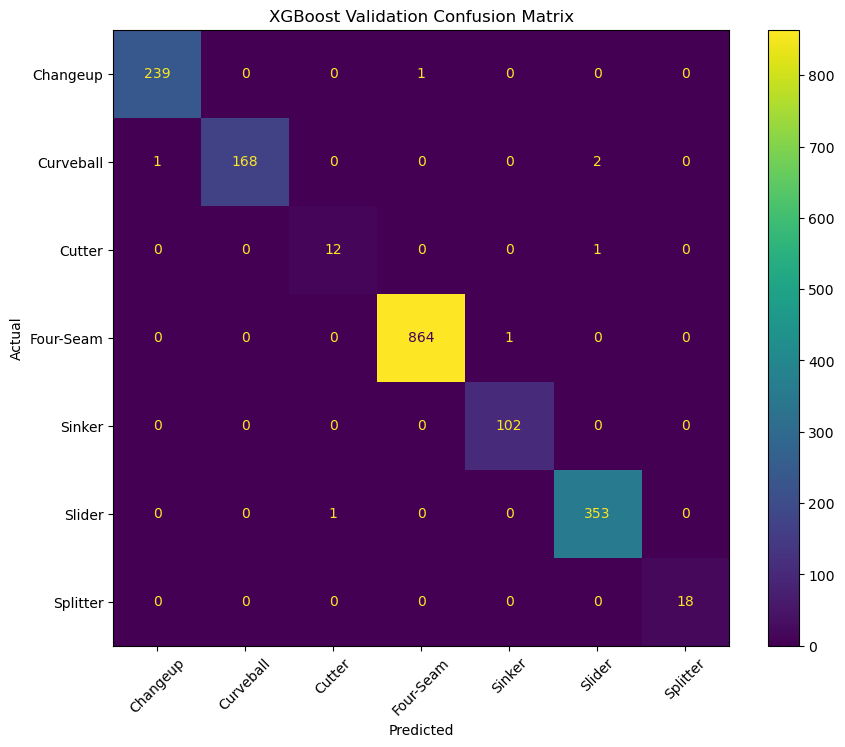

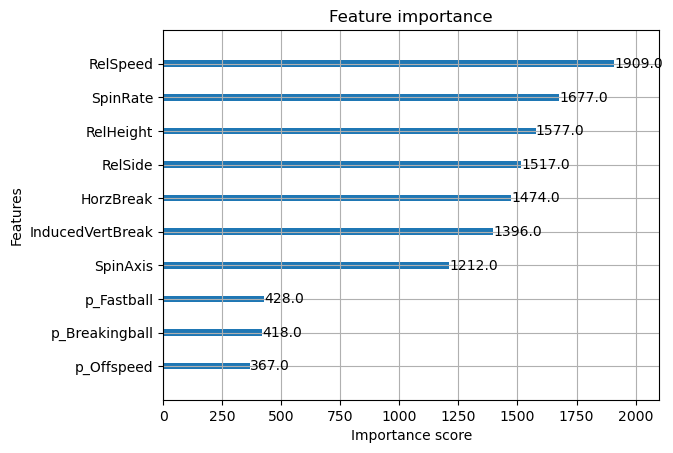

In [ ]:
rhp_indiv_xgb = xgboost_model_indiv(indiv_X_rhp, indiv_y_rhp)

In [ ]:
joblib.dump(lhp_indiv_xgb, "lhp_indiv_xgb.pkl")
lhp_indiv_xgb = joblib.load("lhp_indiv_xgb.pkl")
display(lhp_indiv_xgb)

joblib.dump(rhp_indiv_xgb, "rhp_indiv_xgb.pkl")
rhp_indiv_xgb = joblib.load("rhp_indiv_xgb.pkl")
display(rhp_indiv_xgb)

NameError: name 'lhp_indiv_xgb' is not defined

In [ ]:
def prob_indiv_df(model, df, handedness, label_col="TaggedPitchType"):
    """
    
    """
    df = df[df['PitcherThrows'] == handedness].reset_index(drop=True).copy()
    X_pred = df.copy()
    
    X_pred = (X_pred[['RelSpeed', 'SpinRate', 'SpinAxis', 'InducedVertBreak', 'HorzBreak', 'RelHeight', 'RelSide']].transform(lambda x: (x - x.mean()) / x.std()))

    X_pred.loc[:, 'p_Breakingball'] = df['p_Breakingball']
    X_pred.loc[:, 'p_Fastball'] = df['p_Fastball']
    X_pred.loc[:, 'p_Offspeed'] = df['p_Offspeed']

    cat_dtype = training_data[label_col].astype('category')
    code_to_label = dict(enumerate(cat_dtype.cat.categories))
    class_labels = [code_to_label[c] for c in model.classes_]

    probs = model.predict_proba(X_pred.values)
    probs_df = pd.DataFrame(probs, columns=[f"p_{c}" for c in class_labels])
    probs_df = probs_df.round(3)

    df_w_prob = pd.concat([df, probs_df], axis=1)
    
    return df_w_prob

In [ ]:
test_indiv_data = merged_df[merged_df['TaggedPitchType'] != merged_df['AutoPitchType']].reset_index(drop=True).copy()
test_indiv_data

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup,p_Breakingball,p_Fastball,p_Offspeed
0,17,2025-02-21,14:11:28.90,1,2,"Walton, Ryker",1.028884e+07,1,EKU_COL,"Sanford, Mitchell",6.894070e+05,Left,OLE_REB,Undefined,1,Bottom,0,0,1,Four-Seam,Sinker,BallCalled,Undefined,Undefined,Undefined,0,0,91.33341,-2.816226,-2.792579,2047.277805,223.347860,1:30,5.76786,1.81151,6.09892,-16.98749,16.37654,14.42918,1.74231,0.42904,83.43171,-6.043673,-0.195299,0.415729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.20339,9.56292,-1.60374,50.0,5.54163,5.84703,-132.43500,-7.01774,-14.55291,28.57963,-15.20932,OLE_REB,EKU_COL,OleMiss,D1,SEC,20250221-OleMiss-1,09570730-f090-11ef-b516-25f8a7d41699,90.66583,NaN,NaN,7.90170,NaN,NaN,NaN,NaN,NaN,NaN,31986fae-7fd7-49fb-892d-0c9b3ed15b06,2025-02-21,20:11:28.90,2025-02-21T14:11:28.9018368-06:00,2025-02-21T20:11:28.9018368Z,NaN,v3,21 February 2025 17:00-ekentucky@olemiss,"Duffield, Hayden",1.000078e+09,Right,EKU_COL,938d3dfa-578f-4268-93a3-aa8d2a0b0d7e,54.40126,-133.38142,14.28982,5.76568,-6.51408,-7.60466,-1.80534,6.32895,-7.27645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,Fastball,Fastball,0.000,1.000,0.000
1,19,2025-02-21,14:12:00.87,1,4,"Walton, Ryker",1.028884e+07,1,EKU_COL,"Sanford, Mitchell",6.894070e+05,Left,OLE_REB,Undefined,1,Bottom,0,2,1,Four-Seam,Sinker,InPlay,Undefined,GroundBall,Out,1,0,89.88925,-2.068730,-1.714872,2175.680699,227.578542,1:30,5.66766,1.73860,6.01795,-19.82875,14.70902,14.85438,2.09728,1.38748,82.01262,-5.811790,0.957902,0.422979,60.16180,-66.419896,19.253788,NaN,NaN,NaN,NaN,1.22880,1.22880,-68.373974,0.023608,-8.14071,8.50575,-1.61221,50.0,5.49457,3.28482,-130.47528,-5.32263,-13.98214,28.386

In [ ]:
prob_indiv_df(lhp_indiv_xgb, test_indiv_data, 0)

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup,p_Breakingball,p_Fastball,p_Offspeed,p_Changeup,p_Curveball,p_Cutter,p_Four-Seam,p_Sinker,p_Slider,p_Splitter
0,1,2025-02-21,14:02:52.36,1,1,"Elliott, Hunter",6.955450e+05,0,OLE_REB,"Bejarano, Mauricio",1.000329e+09,Right,EKU_COL,Undefined,1,Top,0,0,0,Four-Seam,Sinker,StrikeCalled,Undefined,Undefined,Undefined,0,0,89.33355,-0.276997,4.350026,2203.614887,132.167696,10:30,5.22699,-2.68740,6.21670,-17.99422,17.21702,-17.58678,3.47110,-0.13083,80.25956,-3.747010,1.186737,0.427083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.39816,9.33898,2.36887,50.0,5.19704,-9.08953,-129.30922,-1.10744,17.34646,30.66937,-16.59455,OLE_REB,EKU_COL,OleMiss,D1,SEC,20250221-OleMiss-1,d5791800-f08e-11ef-b516-25f8a7d41699,88.25556,NaN,NaN,9.07400,NaN,NaN,NaN,NaN,NaN,NaN,31986fae-7fd7-49fb-892d-0c9b3ed15b06,2025-02-21,20:02:52.36,2025-02-21T14:02:52.3694080-06:00,2025-02-21T20:02:52.3694080Z,NaN,v3,21 February 2025 17:00-ekentucky@olemiss,"Smithwick, Campbell",805802.0,Right,OLE_REB,ebd6f9a4-d844-4b8f-9733-c22c00229021,54.28077,-130.32058,15.33469,5.22454,-0.56022,-8.29728,2.67804,-9.66155,8.67323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,Fastball,Fastball,0.000,1.000,0.000,0.000,0.000,0.000,0.899,0.100,0.000,0.000
1,2,2025-02-21,14:03:10.24,1,2,"Elliott, Hunter",6.955450e+05,0,OLE_REB,"Bejarano, Mauricio",1.000329e+09,Right,EKU_COL,Undefined,1,Top,0,0,1,Four-Seam,Sinker,BallCalled,Undefined,Undefined,Undefined,0,0,88.90840,-2.228576,3.686879,2183.741757,129.629962,10:15,5.21500,-2.74463,6.52932,-18.22198,17.10166,-18.99836,1.64677,-0.94085,79.64732,-5.761843,0.242888,0.427764,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [ ]:
prob_indiv_df(rhp_indiv_xgb, test_indiv_data, 1)

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,TaggedGroup,AutoGroup,p_Breakingball,p_Fastball,p_Offspeed,p_Changeup,p_Curveball,p_Cutter,p_Four-Seam,p_Sinker,p_Slider,p_Splitter
0,17,2025-02-21,14:11:28.90,1,2,"Walton, Ryker",10288839.0,1,EKU_COL,"Sanford, Mitchell",6.894070e+05,Left,OLE_REB,Undefined,1,Bottom,0,0,1,Four-Seam,Sinker,BallCalled,Undefined,Undefined,Undefined,0,0,91.33341,-2.816226,-2.792579,2047.277805,223.347860,1:30,5.76786,1.81151,6.09892,-16.98749,16.37654,14.42918,1.74231,0.42904,83.43171,-6.043673,-0.195299,0.415729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.20339,9.56292,-1.60374,50.0,5.54163,5.84703,-132.43500,-7.01774,-14.55291,28.57963,-15.20932,OLE_REB,EKU_COL,OleMiss,D1,SEC,20250221-OleMiss-1,09570730-f090-11ef-b516-25f8a7d41699,90.66583,NaN,NaN,7.90170,NaN,NaN,NaN,NaN,NaN,NaN,31986fae-7fd7-49fb-892d-0c9b3ed15b06,2025-02-21,20:11:28.90,2025-02-21T14:11:28.9018368-06:00,2025-02-21T20:11:28.9018368Z,NaN,v3,21 February 2025 17:00-ekentucky@olemiss,"Duffield, Hayden",1.000078e+09,Right,EKU_COL,938d3dfa-578f-4268-93a3-aa8d2a0b0d7e,54.40126,-133.38142,14.28982,5.76568,-6.51408,-7.60466,-1.80534,6.32895,-7.27645,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,Fastball,Fastball,0.000,1.000,0.000,0.000,0.0,0.0,1.000,0.000,0.0,0.0
1,19,2025-02-21,14:12:00.87,1,4,"Walton, Ryker",10288839.0,1,EKU_COL,"Sanford, Mitchell",6.894070e+05,Left,OLE_REB,Undefined,1,Bottom,0,2,1,Four-Seam,Sinker,InPlay,Undefined,GroundBall,Out,1,0,89.88925,-2.068730,-1.714872,2175.680699,227.578542,1:30,5.66766,1.73860,6.01795,-19.82875,14.70902,14.85438,2.09728,1.38748,82.01262,-5.811790,0.957902,0.422979,60.16180,-66.419896,19.253788,NaN,NaN,NaN,NaN,1.22880,1.22880,

In [ ]:
merged_trackman_games = (pd.concat([prob_indiv_df(rhp_indiv_xgb, training_data_indiv, 1), prob_indiv_df(lhp_indiv_xgb, training_data_indiv, 0), 
                                    prob_indiv_df(rhp_indiv_xgb, test_indiv_data, 1), prob_indiv_df(lhp_indiv_xgb, test_indiv_data, 0)])
                         .reset_index(drop=True)
                         .copy()
                         )
prob_cols = ["p_Changeup", "p_Curveball", "p_Cutter", "p_Four-Seam", "p_Sinker", "p_Slider", "p_Splitter"]
group_prob_cols = ['p_Breakingball', 'p_Fastball', 'p_Offspeed']
merged_trackman_games.loc[:, "predTaggedGroup"] = merged_trackman_games[group_prob_cols].idxmax(axis=1)
merged_trackman_games.loc[:, "predTaggedGroup"] = merged_trackman_games["predTaggedGroup"].apply(lambda x: str(x.split('_')[1]))
merged_trackman_games.loc[:, "predTaggedPitch"] = merged_trackman_games[prob_cols].idxmax(axis=1)
merged_trackman_games.loc[:, "predTaggedPitch"] = merged_trackman_games["predTaggedPitch"].apply(lambda x: str(x.split('_')[1]))

In [ ]:
merged_trackman_games.to_csv('../../Files/pitch_class_trackman_games.csv')

https://medium.com/mlb-technology/mlb-pitch-classification-64a1e32ee079

# Unsupervised Classification Effort

- Normalize handedness metrics (RelSide and HorzBreak) to create a bigger cluster
- Gather features
- Clean data for obvious outlier pitches
- Standardize metrics - globally? 
- Use GMM, combined with BIC to iterate through the different k's (# of clusters or different pitch types)

In [144]:
#Necessary libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.mixture import GaussianMixture
pd.set_option('display.float_format', '{:.3f}'.format)

In [137]:
master_trackman = pd.read_csv('../../Files/merged_trackman_games.csv')
master_trackman

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence
0,1,2025-03-25,18:08:29.92,1,1,"Martin, Landon",1000364953.00,Right,CAL_FUL,"Watson, Rex",1000336187.00,Left,SAN_TOR,Undefined,1,Top,0,0,0,Fastball,Four-Seam,InPlay,Undefined,Popup,Out,1,0,88.86,-1.47,-1.38,1973.86,199.69,12:45,5.82,0.89,5.87,-20.14,15.63,5.15,2.78,0.03,80.49,-5.28,-0.46,0.43,82.05,73.61,-26.91,NaN,NaN,NaN,NaN,NaN,34.69,NaN,NaN,-3.08,8.82,-0.78,50.00,5.69,2.89,-128.91,-3.92,-5.12,29.56,-17.49,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,d4cb7a60-09de-11f0-91ec-41cc551cf82d,87.57,110.07,NaN,8.37,NaN,NaN,NaN,0.66,3.16,-0.65,4f69f254-7555-401e-b034-118e07d33b1e,2025-03-26,01:08:29.92,2025-03-25T18:08:29.9246592-07:00,2025-03-26T01:08:29.9246592Z,NaN,v3,471254.00,5320.00,25 March 2025 21:00-sandiego@calstfull,"Ortega, Max",703672,Right,CAL_FUL,dc341f6c-8981-4044-addd-07f5b0d70724,54.63,-129.97,14.78,5.82,-3.29,-8.75,-0.88,3.07,-2.56,NaN,0.66,30.28,-13.00,3.70,-0.22,-0.46,0.20,0.03,-0.03,3.16,115.45,-29.53,3.84,-0.86,0.30,-0.13,0.04,-0.01,-0.65,-15.37,-3.68,1.44,0.01,-0.33,0.15,0.01,-0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,Medium,Undefined,NaN,NaN,NaN
1,2,2025-03-25,18:09:07.68,2,1,"Martin, Landon",1000364953.00,Right,CAL_FUL,"Libed, Nico",822297.00,Right,SAN_TOR,Undefined,1,Top,1,0,0,Fastball,Four-Seam,StrikeCalled,Undefined,Undefined,Undefined,0,0,88.81,-2.89,-1.99,2086.80,201.09,12:45,5.81,0.92,5.80,-19.78,16.17,5.75,1.47,-0.45,80.64,-6.62,-0.96,0.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.56,9.51,-0.76,50.00,5.56,4.22,-128.67,-7.11,-5.91,29.08,-16.38,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,eb4f2e30-09de-11f0-91ec-41cc551cf82d,87.35,NaN,NaN,8.17,NaN,NaN,NaN,NaN,NaN,NaN,4f69f254-7555-401e-b034-118e07d33b1e,2025-03-26,01:09:07.68,2025-03-25T18:0

In [138]:
def mirror_handedness(row):
    
    # Encode 0 to LHP and 1 to RHP
    row['handedness_encode'] = int(row['PitcherThrows'] == 'Right')
    
    # Mirror if left
    if row['handedness_encode'] == 0:
        row['HorzBreak'] *= -1
        row['RelSide'] *= -1
        row['HorzApprAngle'] *= -1
    return row

encoded_trackman = master_trackman.apply(mirror_handedness, axis = 1)
encoded_trackman
    

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,BatterId,BatterSide,BatterTeam,PitcherSet,Inning,Top/Bottom,Outs,Balls,Strikes,TaggedPitchType,AutoPitchType,PitchCall,KorBB,TaggedHitType,PlayResult,OutsOnPlay,RunsScored,RelSpeed,VertRelAngle,HorzRelAngle,SpinRate,SpinAxis,Tilt,RelHeight,RelSide,Extension,VertBreak,InducedVertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,ExitSpeed,Angle,Direction,HitSpinRate,PositionAt110X,PositionAt110Y,PositionAt110Z,Distance,LastTrackedDistance,Bearing,HangTime,pfxx,pfxz,x0,y0,z0,vx0,vy0,vz0,ax0,ay0,az0,HomeTeam,AwayTeam,Stadium,Level,League,GameID,PitchUID,EffectiveVelo,MaxHeight,MeasuredDuration,SpeedDrop,PitchLastMeasuredX,PitchLastMeasuredY,PitchLastMeasuredZ,ContactPositionX,ContactPositionY,ContactPositionZ,GameUID,UTCDate,UTCTime,LocalDateTime,UTCDateTime,AutoHitType,System,HomeTeamForeignID,AwayTeamForeignID,GameForeignID,Catcher,CatcherId,CatcherThrows,CatcherTeam,PlayID,PitchTrajectoryXc0,PitchTrajectoryXc1,PitchTrajectoryXc2,PitchTrajectoryYc0,PitchTrajectoryYc1,PitchTrajectoryYc2,PitchTrajectoryZc0,PitchTrajectoryZc1,PitchTrajectoryZc2,HitSpinAxis,HitTrajectoryXc0,HitTrajectoryXc1,HitTrajectoryXc2,HitTrajectoryXc3,HitTrajectoryXc4,HitTrajectoryXc5,HitTrajectoryXc6,HitTrajectoryXc7,HitTrajectoryXc8,HitTrajectoryYc0,HitTrajectoryYc1,HitTrajectoryYc2,HitTrajectoryYc3,HitTrajectoryYc4,HitTrajectoryYc5,HitTrajectoryYc6,HitTrajectoryYc7,HitTrajectoryYc8,HitTrajectoryZc0,HitTrajectoryZc1,HitTrajectoryZc2,HitTrajectoryZc3,HitTrajectoryZc4,HitTrajectoryZc5,HitTrajectoryZc6,HitTrajectoryZc7,HitTrajectoryZc8,ThrowSpeed,PopTime,ExchangeTime,TimeToBase,CatchPositionX,CatchPositionY,CatchPositionZ,ThrowPositionX,ThrowPositionY,ThrowPositionZ,BasePositionX,BasePositionY,BasePositionZ,ThrowTrajectoryXc0,ThrowTrajectoryXc1,ThrowTrajectoryXc2,ThrowTrajectoryYc0,ThrowTrajectoryYc1,ThrowTrajectoryYc2,ThrowTrajectoryZc0,ThrowTrajectoryZc1,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,handedness_encode
0,1,2025-03-25,18:08:29.92,1,1,"Martin, Landon",1000364953.00,Right,CAL_FUL,"Watson, Rex",1000336187.00,Left,SAN_TOR,Undefined,1,Top,0,0,0,Fastball,Four-Seam,InPlay,Undefined,Popup,Out,1,0,88.86,-1.47,-1.38,1973.86,199.69,12:45,5.82,0.89,5.87,-20.14,15.63,5.15,2.78,0.03,80.49,-5.28,-0.46,0.43,82.05,73.61,-26.91,NaN,NaN,NaN,NaN,NaN,34.69,NaN,NaN,-3.08,8.82,-0.78,50.00,5.69,2.89,-128.91,-3.92,-5.12,29.56,-17.49,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,d4cb7a60-09de-11f0-91ec-41cc551cf82d,87.57,110.07,NaN,8.37,NaN,NaN,NaN,0.66,3.16,-0.65,4f69f254-7555-401e-b034-118e07d33b1e,2025-03-26,01:08:29.92,2025-03-25T18:08:29.9246592-07:00,2025-03-26T01:08:29.9246592Z,NaN,v3,471254.00,5320.00,25 March 2025 21:00-sandiego@calstfull,"Ortega, Max",703672,Right,CAL_FUL,dc341f6c-8981-4044-addd-07f5b0d70724,54.63,-129.97,14.78,5.82,-3.29,-8.75,-0.88,3.07,-2.56,NaN,0.66,30.28,-13.00,3.70,-0.22,-0.46,0.20,0.03,-0.03,3.16,115.45,-29.53,3.84,-0.86,0.30,-0.13,0.04,-0.01,-0.65,-15.37,-3.68,1.44,0.01,-0.33,0.15,0.01,-0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,High,High,High,Medium,Undefined,NaN,NaN,NaN,1
1,2,2025-03-25,18:09:07.68,2,1,"Martin, Landon",1000364953.00,Right,CAL_FUL,"Libed, Nico",822297.00,Right,SAN_TOR,Undefined,1,Top,1,0,0,Fastball,Four-Seam,StrikeCalled,Undefined,Undefined,Undefined,0,0,88.81,-2.89,-1.99,2086.80,201.09,12:45,5.81,0.92,5.80,-19.78,16.17,5.75,1.47,-0.45,80.64,-6.62,-0.96,0.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.56,9.51,-0.76,50.00,5.56,4.22,-128.67,-7.11,-5.91,29.08,-16.38,CAL_FUL,SAN_TOR,GoodwinField,D1,BW,20250325-GoodwinField-1,eb4f2e30-09de-11f0-91ec-41cc551cf82d,87.35,NaN,NaN,8.17,NaN,NaN,NaN,NaN,NaN,NaN,4f69f254-7555-401e-b034-118e07d33b1e,2025-03-26,01:09:0

In [139]:
id_cols = ['Pitcher']
feature_cols = ['RelSpeed', 'SpinRate', 'SpinAxis', 'RelHeight', 'RelSide', 'InducedVertBreak', 'HorzBreak', 'VertApprAngle', 'HorzApprAngle']

In [140]:
training_df = encoded_trackman[encoded_trackman['PitcherTeam'] == 'CSD_TRI'][id_cols + feature_cols]
training_df.sample(20)

,Pitcher,RelSpeed,SpinRate,SpinAxis,RelHeight,RelSide,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle
15311,"Hasegawa, Sam",90.30,2564.25,203.20,5.80,2.34,11.33,-4.37,-5.27,-1.48
23087,"Dalquist, Matthew",87.83,2379.14,205.39,5.59,1.26,21.11,9.38,-3.30,1.40
24781,"Hasegawa, Sam",89.20,2385.16,157.23,5.74,2.35,12.73,4.78,-6.77,-3.05
16295,"Seid, Spencer",88.37,2126.54,124.74,4.65,2.38,15.50,20.61,-3.51,0.40
18493,"Remmers, Ethan",87.24,1986.27,127.36,5.52,1.70,11.30,13.18,-6.72,-1.05
28058,"Gregson, Niccolas",88.20,2215.99,189.04,5.44,1.32,19.45,2.91,-6.29,-1.53
22132,"Seid, Spencer",76.62,2058.13,272.72,4.89,2.18,0.96,-9.91,-8.05,-5.29
24852,"Seid, Spencer",91.37,2135.34,144.35,5.00,2.02,20.87,14.10,-3.01,-0.68
19259,"Seid, Spencer",90.41,2182.17,135.41,4.66,2.13,18.35,16.83,-3.83,-1.40
30164,"Dalquist, Matthew",90.69,2532.10,211.01,5.54,1.21,22.35,12.61,-6.43,0.25


In [200]:
unique_pitchers = ['King, Devon', 'Murdock, Steele', 'Davidson, Garrett', 'Weber, Chapman', 'Villar, Jake', 'Gregson, Niccolas', 'Ries, Nathan', 'Cazares, Julian', 'Remmers, Ethan', 'Pelzman, Harry']

#Standardizing metrics per pitcher
scaled_df = training_df.copy()
for pitcher, group in training_df.groupby('Pitcher'):
    scaler = StandardScaler()
    scaled_df.loc[group.index, feature_cols] = scaler.fit_transform(group[feature_cols])
    
seid = scaled_df[scaled_df['Pitcher'] == 'Gregson, Niccolas']
seid

    

,Pitcher,RelSpeed,SpinRate,SpinAxis,RelHeight,RelSide,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle
2379,"Weber, Chapman",0.455,-0.132,0.674,0.779,-0.248,-0.190,1.218,0.667,0.561
2380,"Weber, Chapman",0.808,1.360,0.578,0.537,-0.423,-0.177,0.866,-0.134,0.396
2381,"Weber, Chapman",-1.994,2.999,-3.085,-1.772,0.775,-2.770,-2.227,-1.149,-1.453
2382,"Weber, Chapman",0.840,0.925,0.548,-0.138,0.341,0.121,1.029,0.458,2.060
2383,"Weber, Chapman",1.000,1.577,0.325,0.272,0.541,0.295,0.297,0.770,-1.118
...,...,...,...,...,...,...,...,...,...,...
34204,"Weber, Chapman",0.108,1.306,-0.057,-0.271,0.259,0.671,-0.944,1.215,0.105
34205,"Weber, Chapman",0.015,1.787,0.002,-0.335,0.185,0.743,-0.706,-1.430,-0.643
34206,"Weber, Chapman",0.062,-0.038,0.055,-0.874,-0.184,0.515,-0.584,0.312,-0.442
34207,"Weber, Chapman",0.070,-0.562,0.352,-0.283,0.377,0.480,0.518,0.438,0.088


## Gaussian Mixture Model

In [189]:
def choose_gmm(X, k_range = range(2, 10), covariance_types = ('full', 'diag'), pca_components = 8):
    #Pipeline: impute, scale, pca, gmm
    
    #Initialize bic choice to none
    best = None
    best_bic = np.inf
    best_model = None
    
    # fill all NaN cases with the pitcher's median
    imputer = SimpleImputer(strategy = 'median')
    # scale
    scaler = StandardScaler()
    # apply pca
    pca = PCA(n_components=pca_components, random_state=42)
    
    X_proc = imputer.fit_transform(X)
    X_proc = scaler.fit_transform(X_proc)
    X_pca = pca.fit_transform(X_proc)
    
    # loop through covariance types and k values to find best number of clusters and best performing gmm
    for cov in covariance_types:
        for k in k_range:
            gmm = GaussianMixture(n_components = k, covariance_type = cov, n_init = 5, random_state = 42)
            gmm.fit(X_pca)
            bic = gmm.bic(X_pca)
            if bic < best_bic:
                best_bic = bic
                best = (k, cov, bic)
                best_model = (imputer, scaler, pca, gmm)
                
    return best, best_model

def fit_gmm(X, best_model):
    
    imputer, scaler, pca, gmm = best_model
    X_proc = imputer.transform(X)
    X_proc = scaler.transform(X_proc)
    X_pca = pca.transform(X_proc)
    
    resp = gmm.predict_proba(X_pca) # soft cluster memberships 
    labels = resp.argmax(axis=1) 
    return {'imputer':imputer, 'scaler':scaler, 'pca':pca, 'gmm':gmm, 'X_pca':X_pca, 'labels':labels, 'proba':resp}
            


In [212]:
X = seid[feature_cols]

best_info, best_model = choose_gmm(X, k_range=range(2,9), covariance_types=('full','diag'), pca_components=8)
gmm_artifacts = fit_gmm(X, best_model)

seid['cluster'] = gmm_artifacts['labels']
for c in range(gmm_artifacts['proba'].shape[1]):
    seid[f'cluster_{c}_prob'] = gmm_artifacts['proba'][:, c]

seid[seid['cluster'] == 0]

,Pitcher,RelSpeed,SpinRate,SpinAxis,RelHeight,RelSide,InducedVertBreak,HorzBreak,VertApprAngle,HorzApprAngle,cluster,cluster_0_prob,cluster_1_prob,cluster_2_prob,cluster_3_prob
4952,"Gregson, Niccolas",0.698,-1.037,0.263,2.222,-0.479,0.352,-0.303,0.242,-0.651,0,0.999,0.000,0.001,0.000
4954,"Gregson, Niccolas",0.616,-0.847,0.622,1.743,-1.040,0.326,0.774,0.811,-0.278,0,0.999,0.000,0.001,0.000
4995,"Gregson, Niccolas",0.651,-0.711,0.634,1.747,-0.385,0.154,0.621,0.616,-0.026,0,1.000,0.000,0.000,0.000
5029,"Gregson, Niccolas",0.438,-0.940,0.566,2.084,-0.592,0.345,0.607,1.166,-0.308,0,1.000,0.000,0.000,0.000
5031,"Gregson, Niccolas",-1.889,1.389,2.730,1.857,-0.658,-1.740,-0.178,-1.286,0.243,0,1.000,0.000,0.000,0.000
26987,"Gregson, Niccolas",0.508,-0.634,0.776,-0.532,-1.371,0.290,1.332,1.188,2.381,0,0.999,0.000,0.001,0.000
27058,"Gregson, Niccolas",-0.018,-0.732,0.714,0.284,0.032,0.684,1.604,1.052,2.364,0,1.000,0.000,0.000,0.000
27985,"Gregson, Niccolas",0.492,-0.927,0.758,-0.172,-0.578,0.118,1.018,0.325,1.992,0,1.000,0.000,0.000,0.000


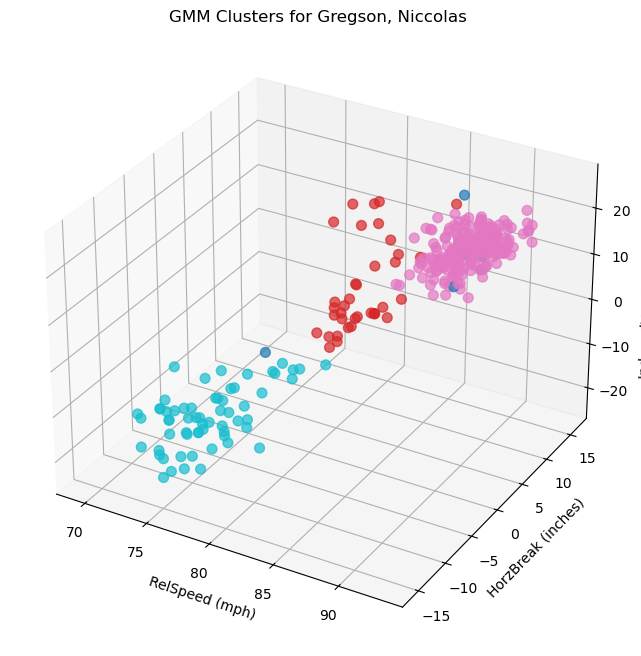

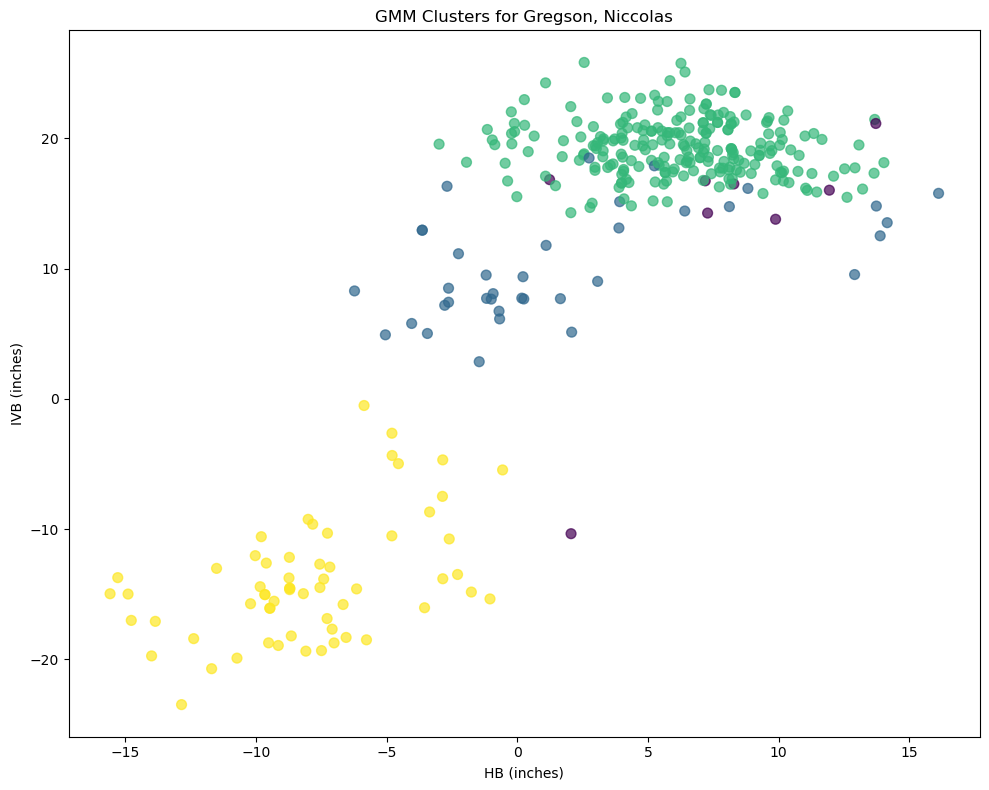

In [216]:
scaled_df = training_df.copy()
pitcher_scalers = {}  # store each pitcher's scaler

# Standardize features per pitcher
for pitcher, group in training_df.groupby('Pitcher'):
    scaler = StandardScaler()
    scaled_df.loc[group.index, feature_cols] = scaler.fit_transform(group[feature_cols])
    pitcher_scalers[pitcher] = scaler

# Filter one pitcher
seid = scaled_df[scaled_df['Pitcher'] == 'Gregson, Niccolas'].copy()

# --- Run GMM on this pitcher ---
X = seid[feature_cols]
best_info, best_model = choose_gmm(X, k_range=range(2,9), covariance_types=('full','diag'))
gmm_artifacts = fit_gmm(X, best_model)

# Add cluster labels and probabilities
seid['cluster'] = gmm_artifacts['labels']
for c in range(gmm_artifacts['proba'].shape[1]):
    seid[f'cluster_{c}_prob'] = gmm_artifacts['proba'][:, c]

# --- Inverse transform to original feature units ---
scaler = pitcher_scalers['Gregson, Niccolas']
X_unscaled = scaler.inverse_transform(seid[feature_cols])
unscaled_df = pd.DataFrame(X_unscaled, columns=feature_cols, index=seid.index)

# Add cluster labels for plotting
unscaled_df['cluster'] = seid['cluster'].values

# --- 3D Scatter plot ---
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    unscaled_df['RelSpeed'],
    unscaled_df['HorzBreak'],
    unscaled_df['InducedVertBreak'],
    c=unscaled_df['cluster'],
    cmap='tab10',
    s=50,
    alpha=0.7
)

ax.set_xlabel('RelSpeed (mph)')
ax.set_ylabel('HorzBreak (inches)')
ax.set_zlabel('InducedVertBreak (inches)')
ax.set_title('GMM Clusters for Gregson, Niccolas')
plt.show()

# --- 2D Scatter Plot ---- #
fig = plt.figure(figsize = (10,8))
plt.scatter(
    unscaled_df['HorzBreak'],
    unscaled_df['InducedVertBreak'],
    c = unscaled_df['cluster'],
    cmap = 'viridis',
    s = 50,
    alpha = 0.7
)

plt.xlabel('HB (inches)')
plt.ylabel('IVB (inches)')
plt.title('GMM Clusters for Gregson, Niccolas')
plt.tight_layout()
plt.show()
